<a href="https://colab.research.google.com/github/matteobrina/DeepLearning/blob/main/Copia_di_Copia_di_modello_caricato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo le dipendenze

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, average_precision_score, f1_score, auc

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

Carico il dataset nella variabile "data"

In [ ]:
data=pd.read_csv(r"creditcardcsvpresent.csv")

Stampo le prime 5 righe del dataset

In [ ]:
data.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


Rimuovo la colonna Transaction date in quanto tutti i valori sono NaN e rimuovo la colonna Merchent_id in quanto ritengo siano informazioni irrilevanti

In [ ]:
data.pop('Transaction date')
data.pop('Merchant_id')

0       3160040998
1       3160040998
2       3160041896
3       3160141996
4       3160241992
           ...    
3070    6661273532
3071    6661273532
3072    6661273533
3073    6661273532
3074    6661273533
Name: Merchant_id, Length: 3075, dtype: int64

Controllo che le colonne siano state rimosse correttamente

In [ ]:
data.head()

,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


Codifico i valori booleani in formato binario

In [ ]:
code={
    "N":0,
    "Y":1
}

In [ ]:
for obj in data.select_dtypes("object"):
    data[obj]=data[obj].map(code)

Divido il dataest in dati di imput ed etichette

In [ ]:
X = data.iloc[:, :-1].values

In [ ]:
y = data["isFradulent"].values

Divido casualmente il dataset in dati di train, validation e di test con un 12,5% di dati di test, 12,5% di dati di validation e 75% di train.

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.25, random_state=11111)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=11111)

RIscalo i valori in modo che siano compresi in un range tra 0 e 1 per evitare fenomeni di exploding gradient

In [ ]:
y_train_r=y_train.reshape(-1, 1)
y_test_r=y_test.reshape(-1, 1)
y_val_r=y_val.reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledy_train = scaler.fit_transform(y_train_r)
rescaledX_test = scaler.fit_transform(X_test)
rescaledy_test = scaler.fit_transform(y_test_r)
rescaledX_val = scaler.fit_transform(X_val)
rescaledy_val = scaler.fit_transform(y_val_r)

Carico il modello addestrato precedentemente

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/modello/mio_modello21')

Valuto il mdoello

In [ ]:
results = model1.evaluate(rescaledX_test, rescaledy_test)

print(results)

13/13 [==============================] - 1s 3ms/step - loss: 0.0534 - accuracy: 0.9870 - binary_crossentropy: 0.0477 - auc: 0.9735 - auc_1: 0.9808
[0.053448066115379333, 0.9870129823684692, 0.0477248914539814, 0.9735426902770996, 0.9807713031768799]


Definisco i grafici di ROC e PR

In [ ]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Credit Card'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

In [ ]:
def plot_pr(y_test, y_pred, model_name):
    fpr, tpr, thr = precision_recall_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # pr curve for random model
    ax.grid(True)
    ax.set(title='PR Curve for {} on Credit Card'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

In [ ]:
y_pred_prob_nn_1 = model1.predict(rescaledX_val)

In [ ]:
y_pred_class_nn_1 = y_pred_prob_nn_1.round()

Stampo roc e pr di validation

roc-auc is 1.000
average precision score is 1.000
pr-auc is 1.000


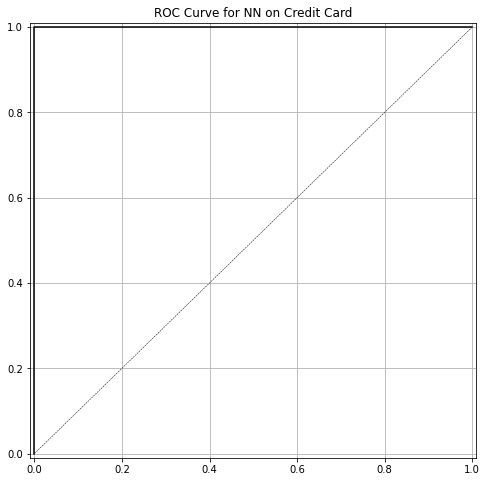

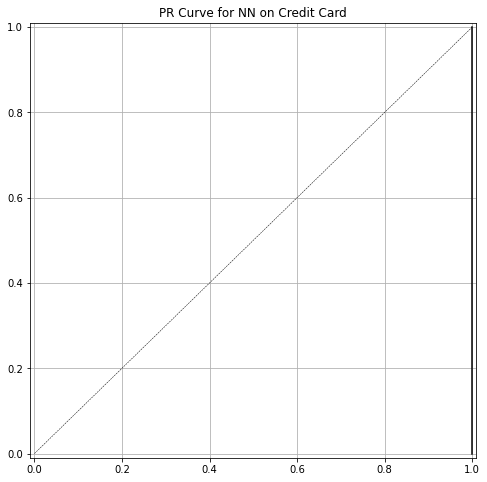

In [ ]:

print('roc-auc is {:.3f}'.format(roc_auc_score(y_val,y_pred_prob_nn_1)))
print('average precision score is {:.3f}'.format(average_precision_score(y_val,y_pred_prob_nn_1)))
x, y, z=precision_recall_curve(y_val, y_pred_prob_nn_1)
print('pr-auc is {:.3f}'.format(auc(y, x)))


plot_roc(y_val, y_pred_prob_nn_1, 'NN')
plot_pr(y_val, y_pred_prob_nn_1, 'NN')

In [ ]:
y_pred_prob_nn_1 = model1.predict(rescaledX_test)

In [ ]:
y_pred_class_nn_1 = y_pred_prob_nn_1.round()

Stampo ROC e PR di test

roc-auc is 0.998
average precision score is 0.990
pr-auc is 0.990


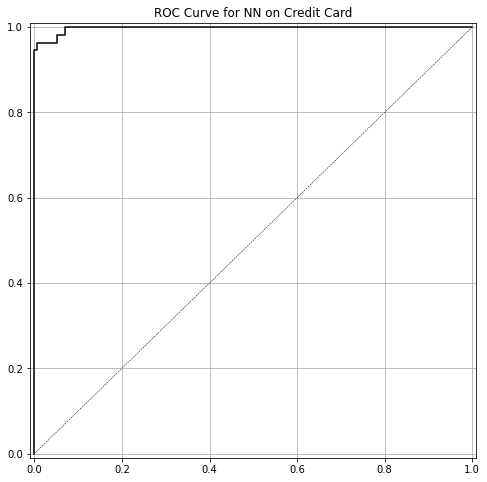

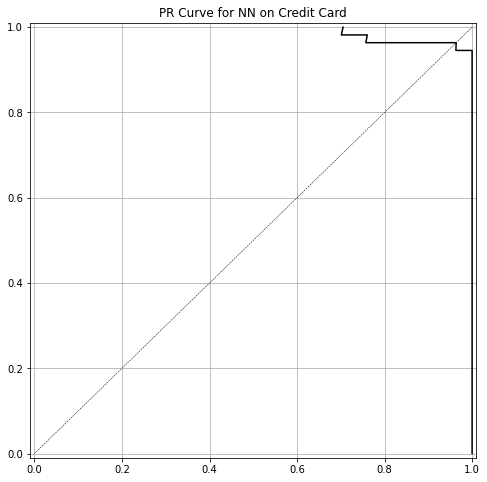

In [ ]:

print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))
print('average precision score is {:.3f}'.format(average_precision_score(y_test,y_pred_prob_nn_1)))
x, y, z=precision_recall_curve(y_test, y_pred_prob_nn_1)
print('pr-auc is {:.3f}'.format(auc(y, x)))



plot_roc(y_test, y_pred_prob_nn_1, 'NN')
plot_pr(y_test, y_pred_prob_nn_1, 'NN')

Carico l'history del training della rete

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/modello/trainHistoryDict12', 'rb') as file_pi:
        history_dict=pickle.load(file_pi)

Plotto l'andamento di training e validation loss, binary crossentropy, accuracy, roc e pr

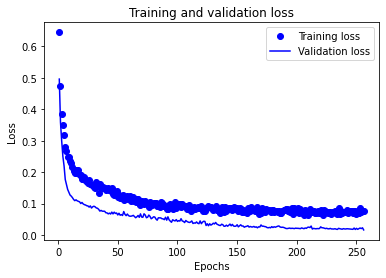

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
binary_crossentropy = history_dict['binary_crossentropy']
val_binary_crossentropy = history_dict['val_binary_crossentropy']
pr_auc = history_dict['auc']
pr_val_auc = history_dict['val_auc']
roc_auc = history_dict['auc_1']
roc_val_auc = history_dict['val_auc_1']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

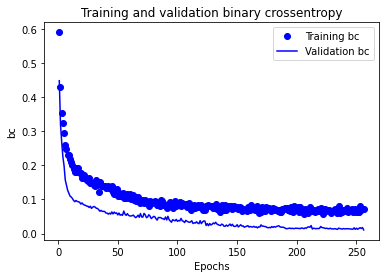

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, binary_crossentropy, 'bo', label='Training bc')
plt.plot(epochs, val_binary_crossentropy, 'b', label='Validation bc')
plt.title('Training and validation binary crossentropy')
plt.xlabel('Epochs')
plt.ylabel('bc')
plt.legend()

plt.show()

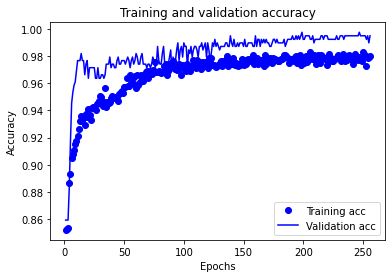

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

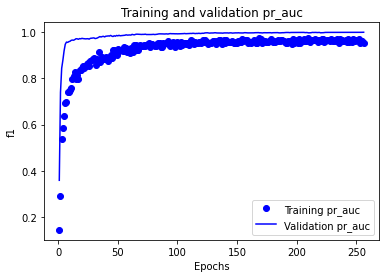

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, pr_auc, 'bo', label='Training pr_auc')
plt.plot(epochs, pr_val_auc, 'b', label='Validation pr_auc')
plt.title('Training and validation pr_auc')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

plt.show()

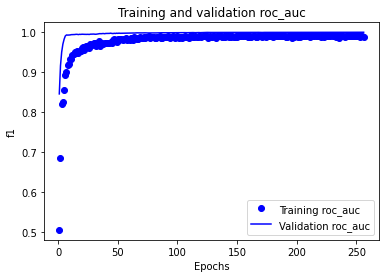

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, roc_auc, 'bo', label='Training roc_auc')
plt.plot(epochs, roc_val_auc, 'b', label='Validation roc_auc')
plt.title('Training and validation roc_auc')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

plt.show()

In [ ]:
epochs

range(1, 257)